In [117]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from minisom import MiniSom  
from sklearn.cluster import KMeans
from scipy import cluster
from matplotlib.gridspec import GridSpec

In [118]:
print("SOM Assignment - chainlink data set")

SOM Assignment - chainlink data set


In [119]:
chainlink = np.genfromtxt('chainlink.vec', skip_header=4, usecols=list(range(3)))

In [120]:
chainlink_som_small = MiniSom(20, 25, 3, sigma=10, learning_rate=0.5,random_seed=10)
chainlink_som_small.train_random(chainlink, 10000)
chainlink_som_big = MiniSom(100, 60, 3, sigma=20, learning_rate=0.5,random_seed=10)
chainlink_som_big.train_random(chainlink, 10000)

In [121]:
# EVALUATION 

In [122]:
print("Ev Small SOM")
print(chainlink_som_small.quantization_error(chainlink))
print(chainlink_som_small.topographic_error(chainlink))
print("Mean of Quantization error:")
print(chainlink_som_small.quantization_error(chainlink)/20*25)


print("Ev Big SOM")
print(chainlink_som_big.quantization_error(chainlink))
print(chainlink_som_big.topographic_error(chainlink))

print("Mean of Quantization error:")
print(chainlink_som_big.quantization_error(chainlink)/100*60)


Ev Small SOM
0.07262317695959422
0.003
Mean of Quantization error:
0.09077897119949277
Ev Big SOM
0.012874399538960055
0.003
Mean of Quantization error:
0.007724639723376034


In [123]:
def winners_labels(som,weights,labels,d1,d2):
    winners_labels = np.zeros(shape=(d1,d2))
    for cnt, xx in enumerate (weights):
        w = som.winner(xx)
        l = labels[cnt]
        winners_labels[w[0],w[1]] = l
    return winners_labels

def dif_matrix(label_matrix):
    dif_mat = np.zeros(shape=label_matrix.shape)
    for i,row in enumerate(label_matrix):
        for j,label in enumerate(row):
            if i < label_matrix.shape[0]-1 and label_matrix[i][j] != label_matrix[i+1][j]:
                dif_mat[i][j] = 1
            elif j < label_matrix.shape[1]-1 and label_matrix[i][j] != label_matrix[i][j+1]:
                dif_mat[i][j] = 1
    return dif_mat

#dif_matrix(winners_labels(chainlink_som_small,weights,labels,d1,d2))

#print(np.unique(dif_matrix(winners_labels(chainlink_som_small,weights,labels,d1,d2))))

In [124]:
def plot_with_labelling(som, d1, d2, labels, coloring_labels, rweights, debug=False):

    plt.figure(figsize=(d1//2, d2//2))
    # Plotting the response for each pattern in the iris dataset
    #win_map = som.win_map(rweights)
    #plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
    #plt.colorbar()
    # use different colors and markers for each label
    #markers = ['o', 's', 'D']
    colors = ['C' + str(i) for i in np.unique(coloring_labels)]
    win_labels = winners_labels(som,rweights,labels,d1,d2)

    for cnt, xx in enumerate(rweights):
        w = som.winner(xx)  # getting the winner
        #w = xx
        # palce a marker on the winning position for the sample xx
        plt.plot(w[0]+.5, w[1]+.5, 's', markerfacecolor=colors[coloring_labels[cnt]],
                markeredgecolor=colors[coloring_labels[cnt]], markersize=20, markeredgewidth=2)
    def plot_borders(debug=False):
        border_color = lambda c : c if debug else 'black'
        for i,row in enumerate(win_labels):
            for j,v in enumerate(row):
                if j < win_labels.shape[1]-1 and v != row[j+1]:
                    plt.plot([i,i+1],[j+1,j+1], color=border_color('red'))
                if i < win_labels.shape[0]-1 and v != win_labels[i+1][j]:
                    plt.plot([i+1,i+1],[j,j+1], color=border_color('blue'))    
    plot_borders(debug)
    plt.axis([0, d1, 0, d2])
    
    fig1 = plt.gcf()
    plt.show()
    return fig1
    


In [125]:
def hierarchical_clust(som,d1,d2,n_clusters,ltype):
    weights = som.get_weights().reshape(d1*d2,-1)
    Z= cluster.hierarchy.linkage(weights,ltype)
    
    labels = cluster.hierarchy.cut_tree(Z, n_clusters)
    if type(n_clusters)==int:
        labels = [l[0] for l in labels]
        fig1=plot_with_labelling(som,d1,d2,labels,labels,weights,debug=False) 
        plt.draw()
        fig1.savefig('CHAINLINK-HC'+"_"+str(ltype)+"-"+str(d1)+'x'+str(d2) , dpi=100)
       
    else: 
        coloring_labels = labels.T[0]
        labels = labels.T[1]
        fig1=plot_with_labelling(som,d1,d2,coloring_labels,labels,weights,debug=False)
        plt.draw()
        fig1.savefig('CHAINLINK-HC'+"_"+str(ltype)+"-"+str(d1)+'x'+str(d2) , dpi=100)
    


In [126]:
def hierarchical_clust_e(som,d1,d2,n_clusters,ltype):
    
    weights = som.get_weights().reshape(d1*d2,-1)
    Z= cluster.hierarchy.linkage(weights,ltype)
    
    labels = cluster.hierarchy.cut_tree(Z, n_clusters)
    if type(n_clusters)==int:
        labels = [l[0] for l in labels]
        fig1=plot_with_labelling(som,d1,d2,labels,labels,weights,debug=False) 
        plt.draw()
        fig1.savefig('CHAINLINK-HC'+"_"+str(ltype)+"-"+str(d1)+'x'+str(d2)+"_e" , dpi=100)
   
       
    else: 
        coloring_labels = labels.T[0]
        labels = labels.T[1]
        fig1=plot_with_labelling(som,d1,d2,coloring_labels,labels,weights,debug=False)
        plt.draw()
        fig1.savefig('CHAINLINK-HC'+"_"+str(ltype)+"-"+str(d1)+'x'+str(d2)+"_e" , dpi=100)
   

In [127]:
# ============================================  HIERARCHICAL CLUSTERING ====================================

In [128]:
# SMALL SOM

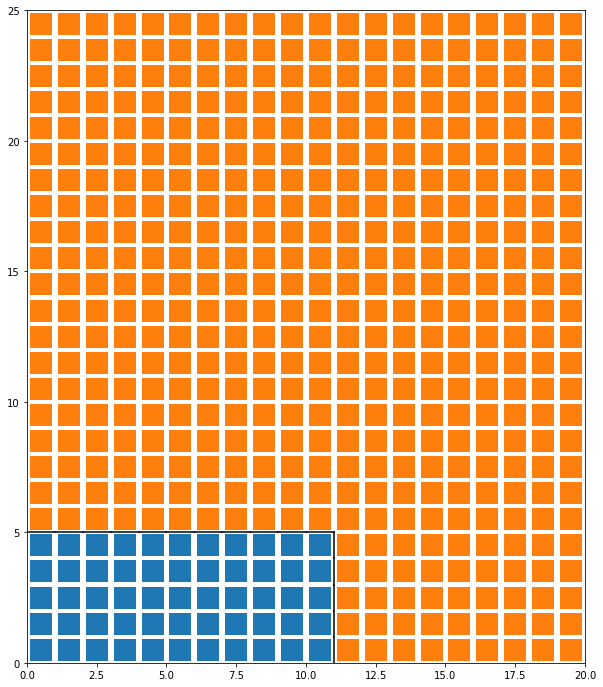

<Figure size 432x288 with 0 Axes>

In [129]:
# CASE 1: linkage type: SINGLE

hierarchical_clust(chainlink_som_small,20,25,2,'single')

In [130]:
# EXTREME VALUES CASE 1

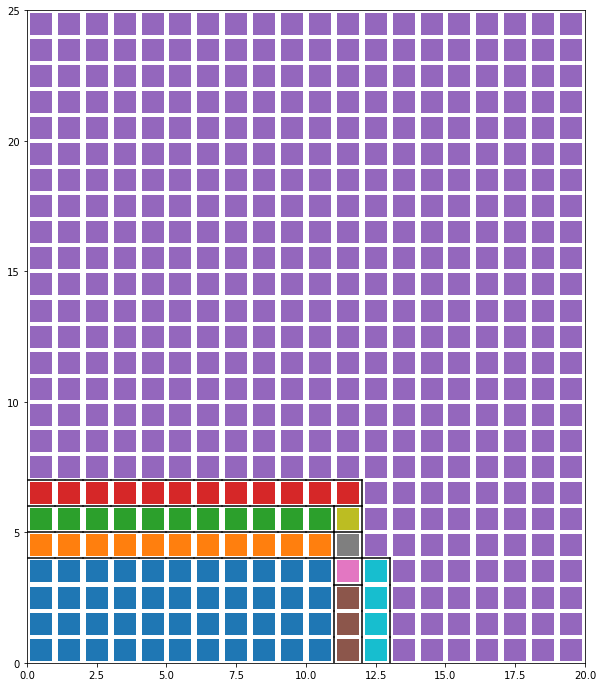

<Figure size 432x288 with 0 Axes>

In [131]:
hierarchical_clust_e(chainlink_som_small,20,25,10,'single')

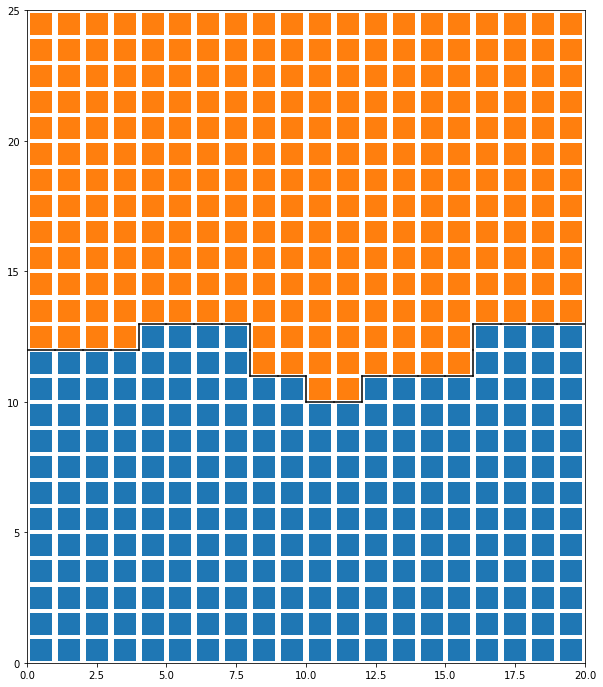

<Figure size 432x288 with 0 Axes>

In [132]:
# CASE 2: linkage type: COMPLETE

hierarchical_clust(chainlink_som_small,20,25,2,'complete')

In [133]:
# EXTREME VALUES CASE 2

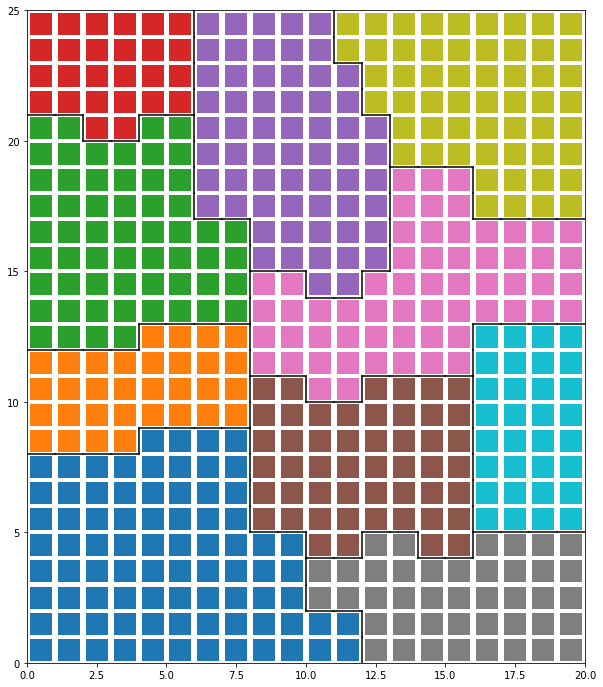

<Figure size 432x288 with 0 Axes>

In [134]:
hierarchical_clust_e(chainlink_som_small,20,25,10,'complete')

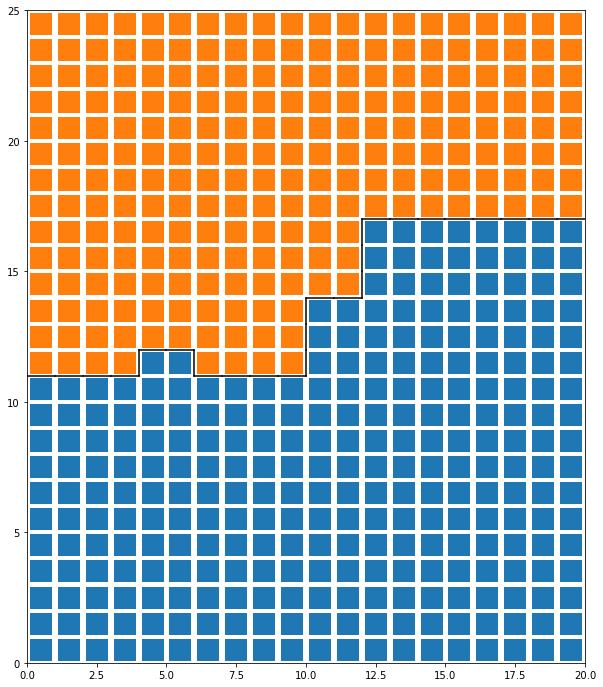

<Figure size 432x288 with 0 Axes>

In [135]:
# CASE 3: linkage type: WARD

hierarchical_clust(chainlink_som_small,20,25,2,'ward')

In [136]:
# EXTREME VALUES CASE 3

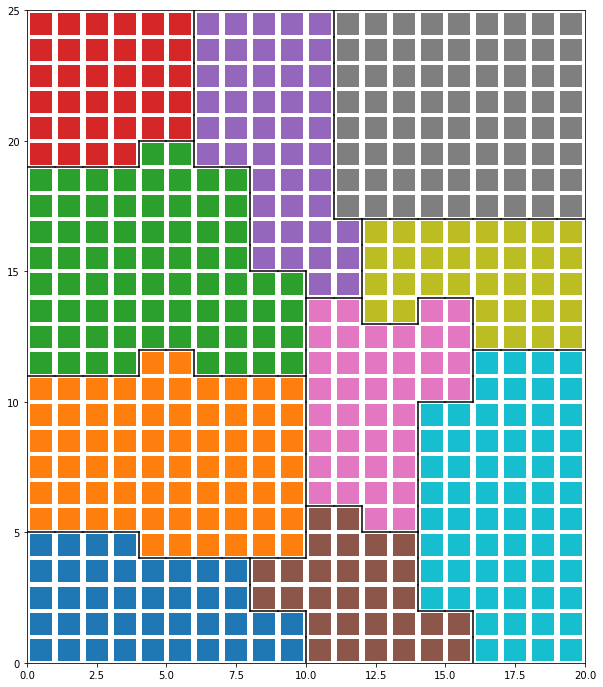

<Figure size 432x288 with 0 Axes>

In [137]:
hierarchical_clust_e(chainlink_som_small,20,25,10,'ward')

In [138]:
# BIG SOM

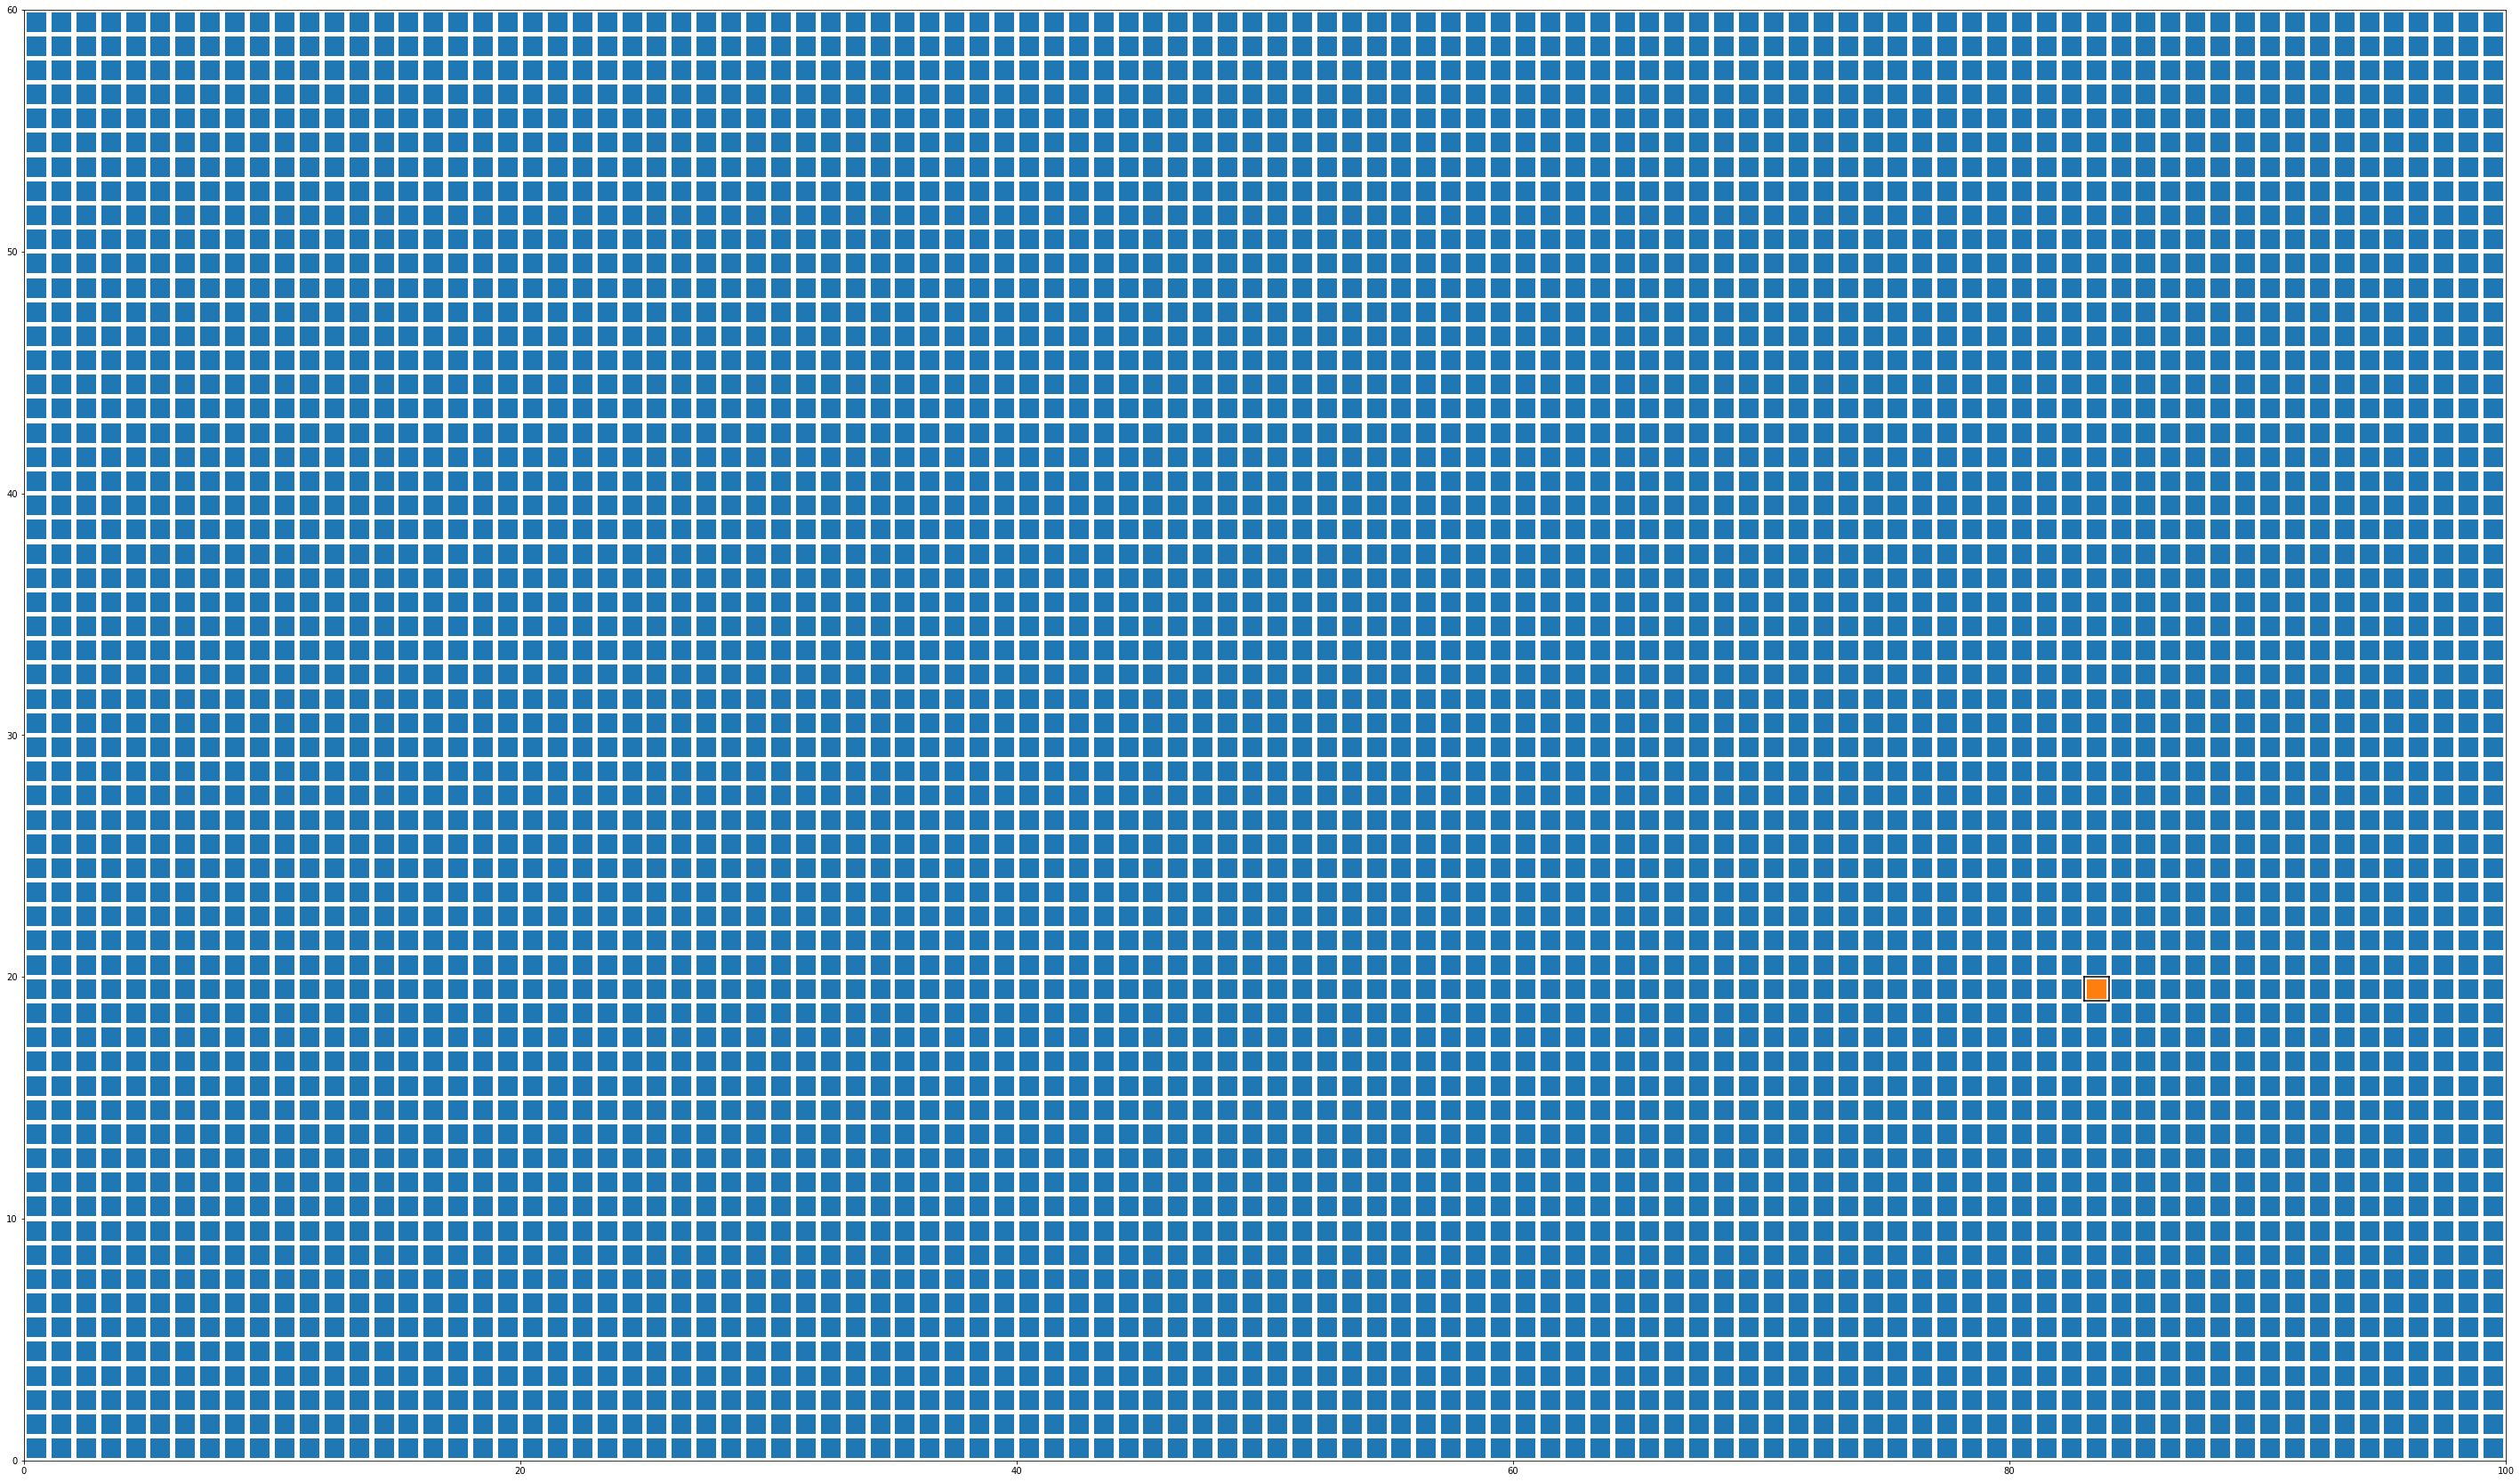

<Figure size 432x288 with 0 Axes>

In [139]:
# CASE 1: linkage type: SINGLE

hierarchical_clust(chainlink_som_big,100,60,2,'single')

In [140]:
# EXTREME VALUES CASE 1

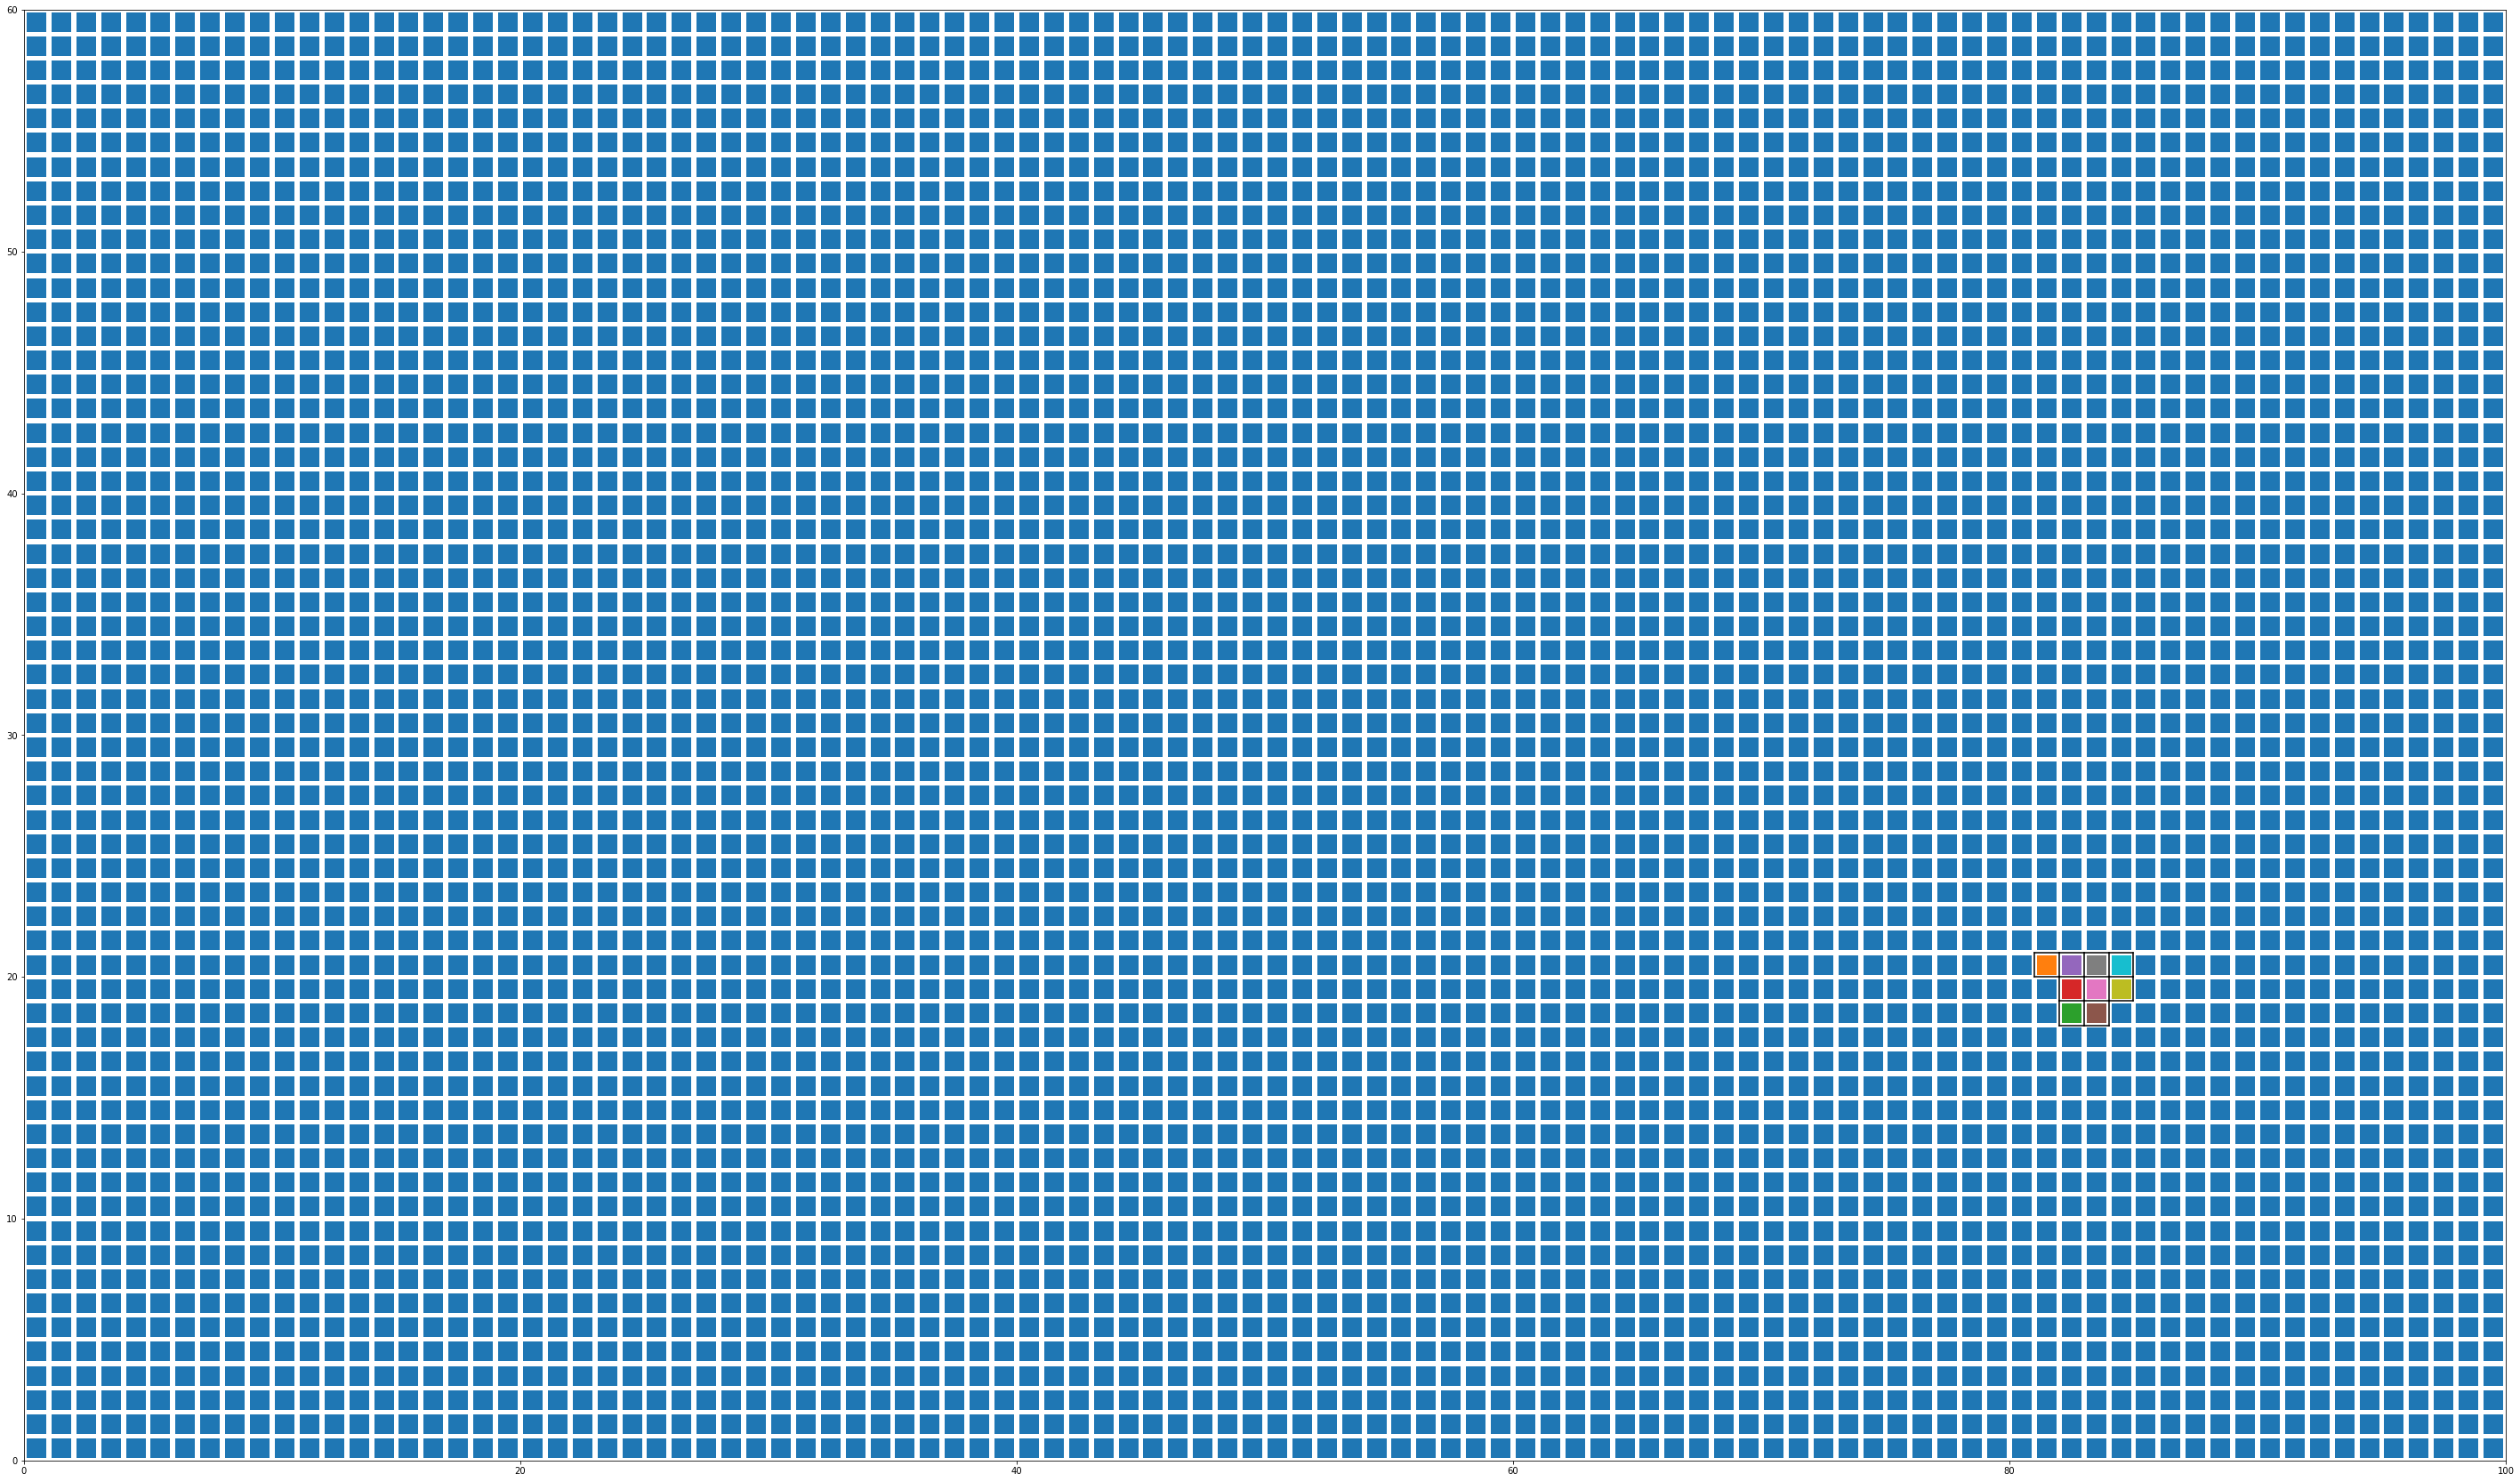

<Figure size 432x288 with 0 Axes>

In [141]:
hierarchical_clust_e(chainlink_som_big,100,60,10,'single')

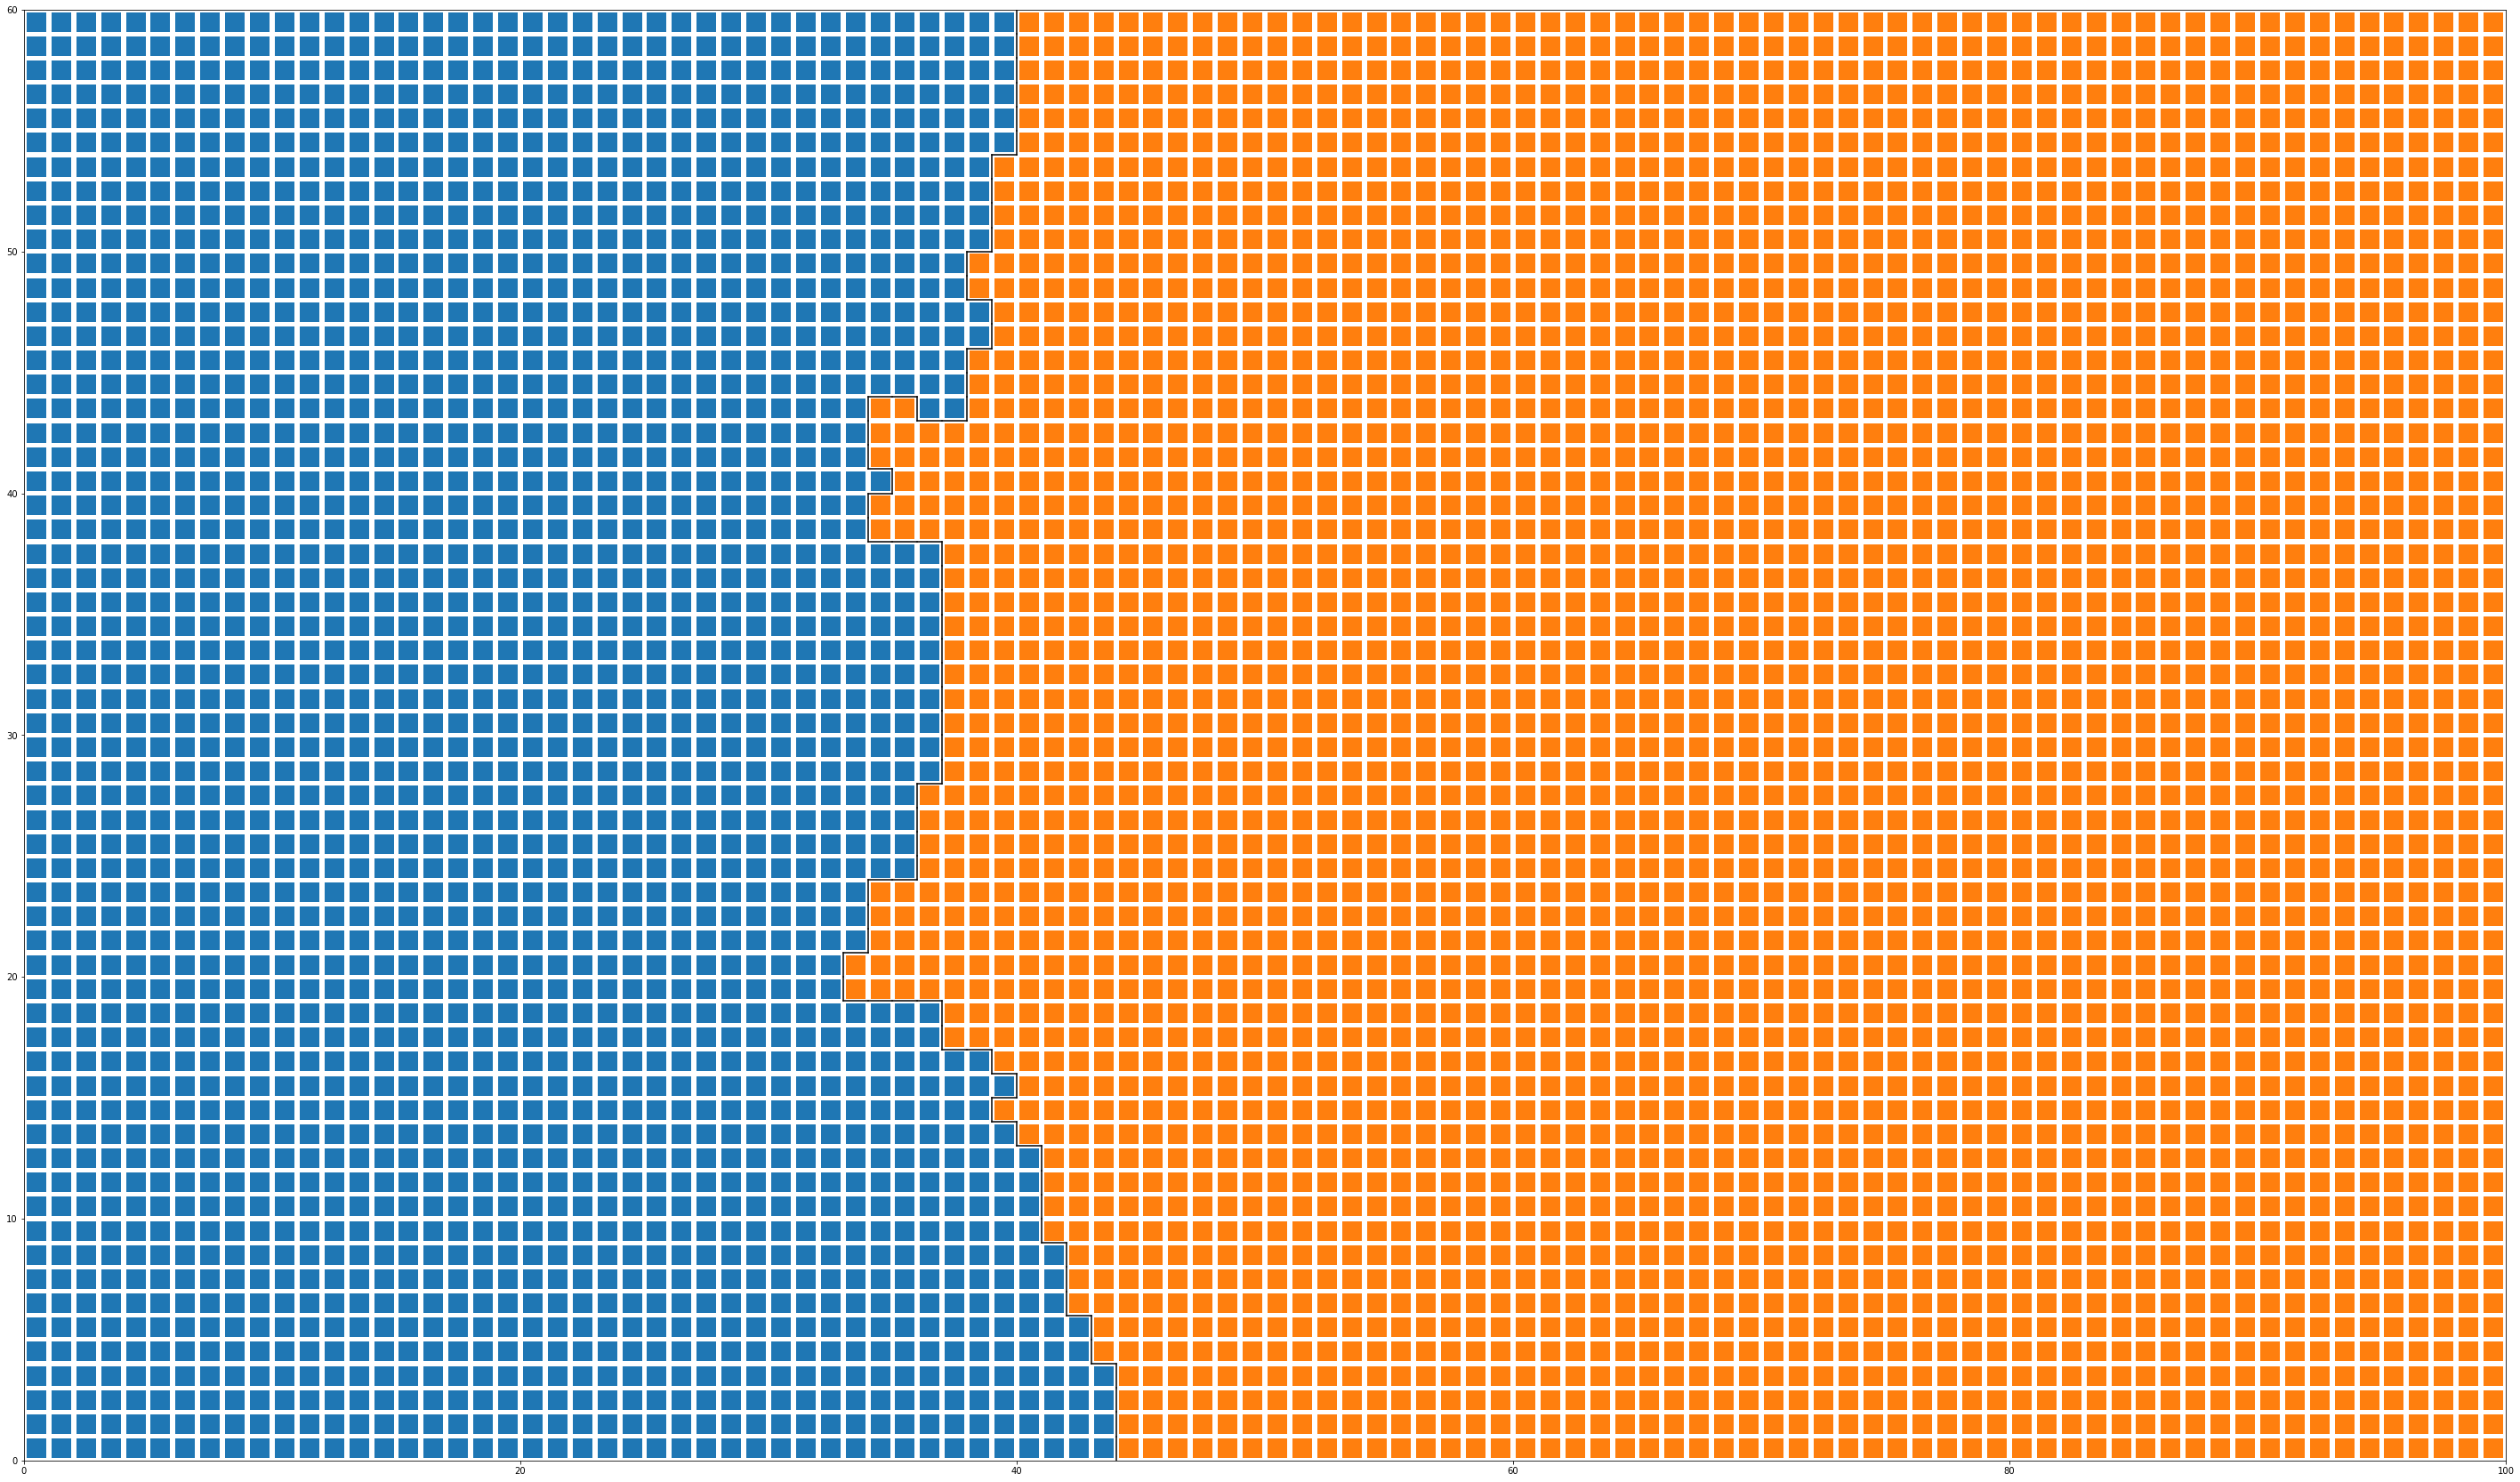

<Figure size 432x288 with 0 Axes>

In [142]:
# CASE 2: linkage type: COMPLETE

hierarchical_clust(chainlink_som_big,100,60,2,'complete')

In [143]:
# EXTREME VALUES CASE 2

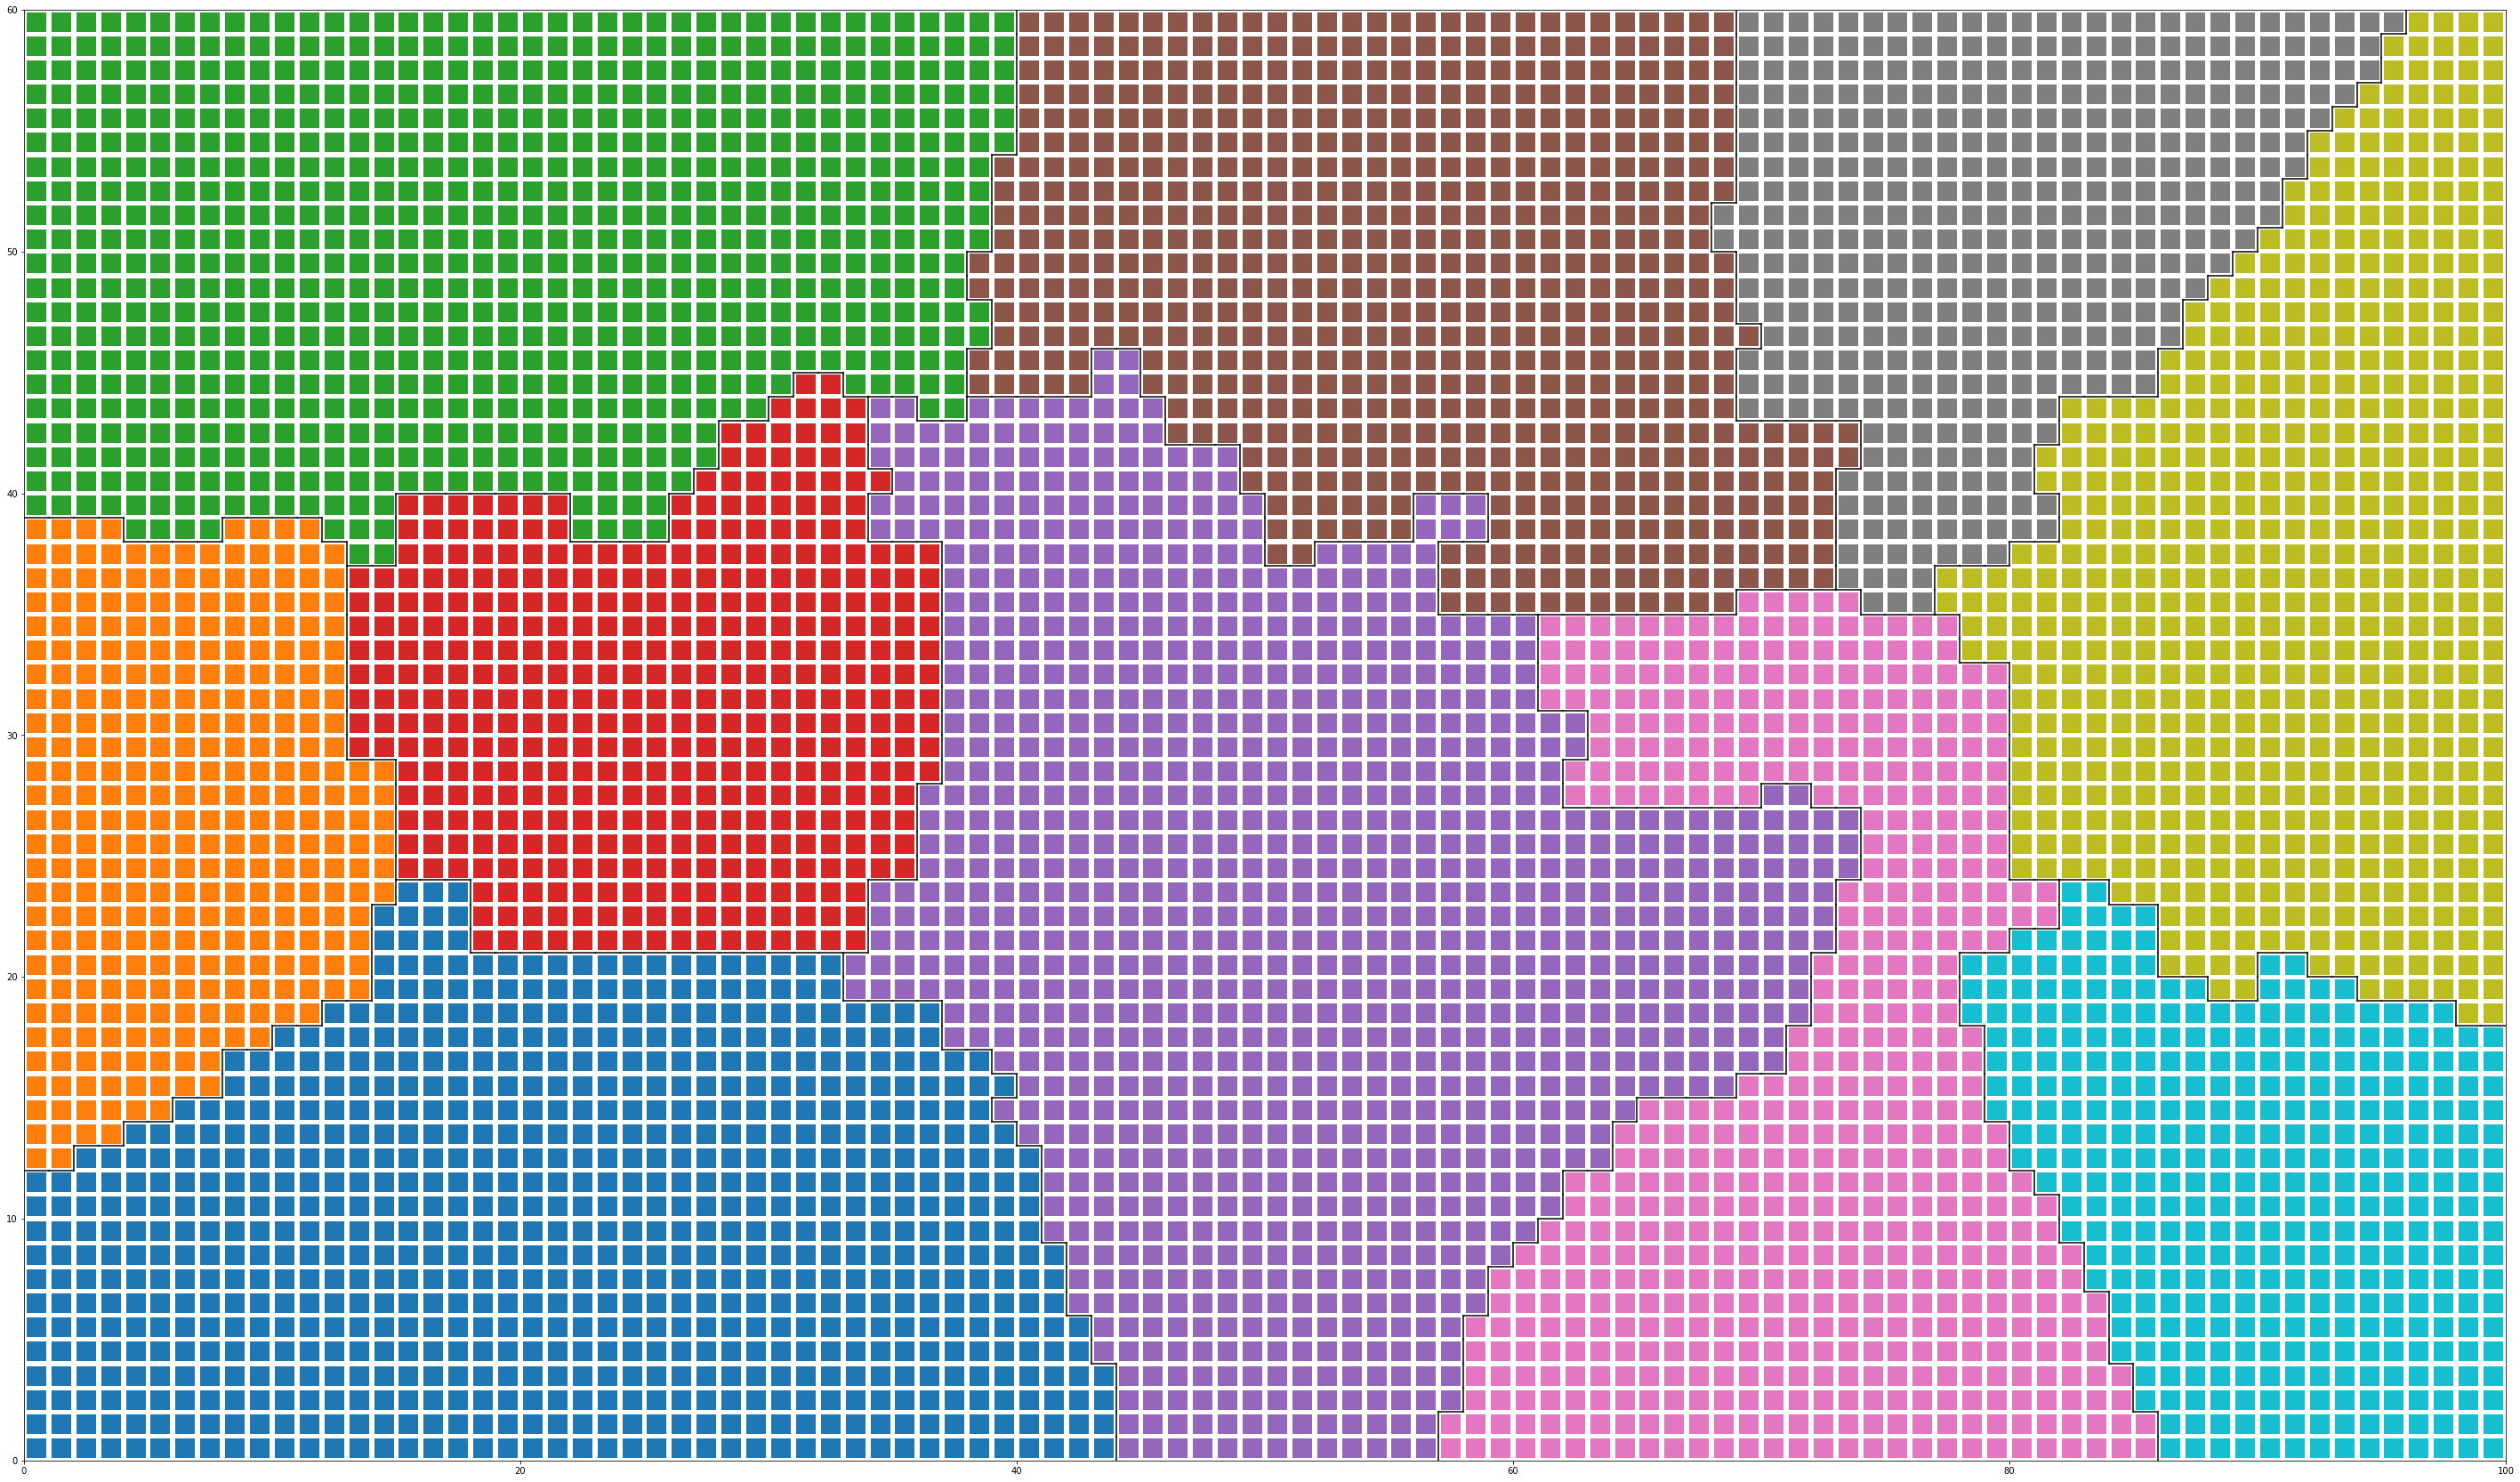

<Figure size 432x288 with 0 Axes>

In [144]:
hierarchical_clust_e(chainlink_som_big,100,60,10,'complete')

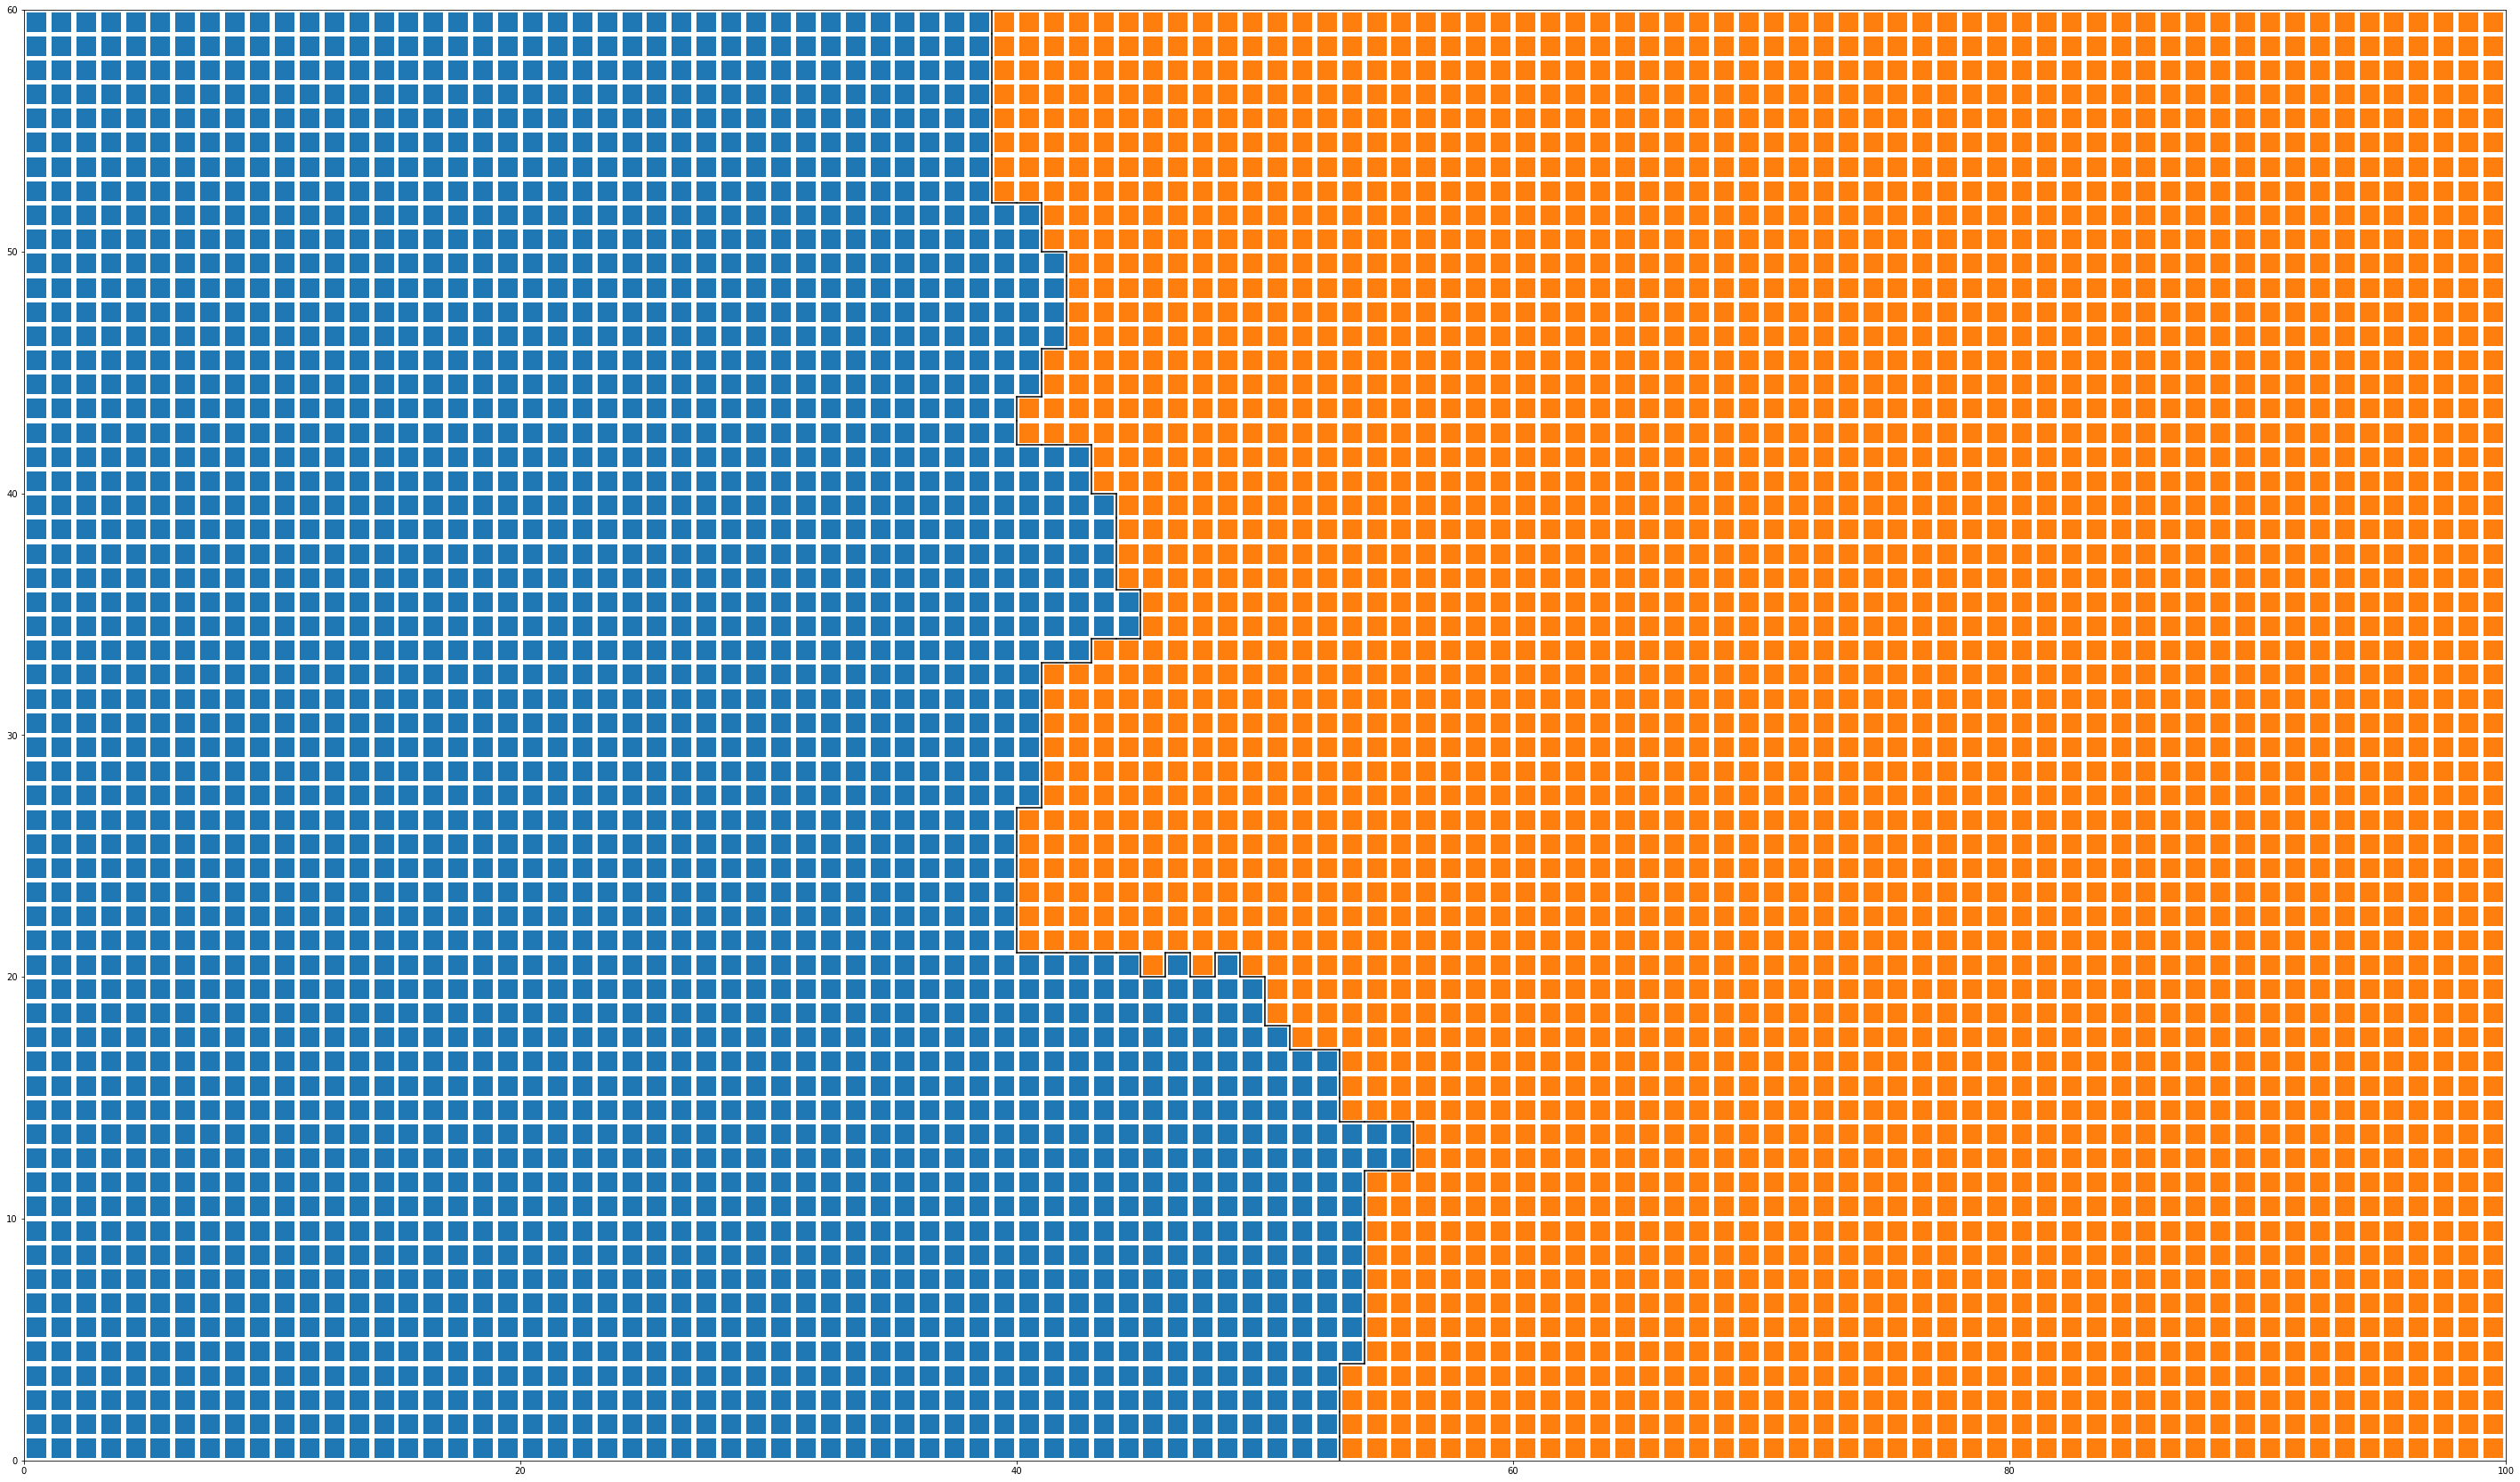

<Figure size 432x288 with 0 Axes>

In [145]:
# CASE 3: linkage type: WARD

hierarchical_clust(chainlink_som_big,100,60,2,'ward')

In [146]:
# EXTREME VALUES CASE 3

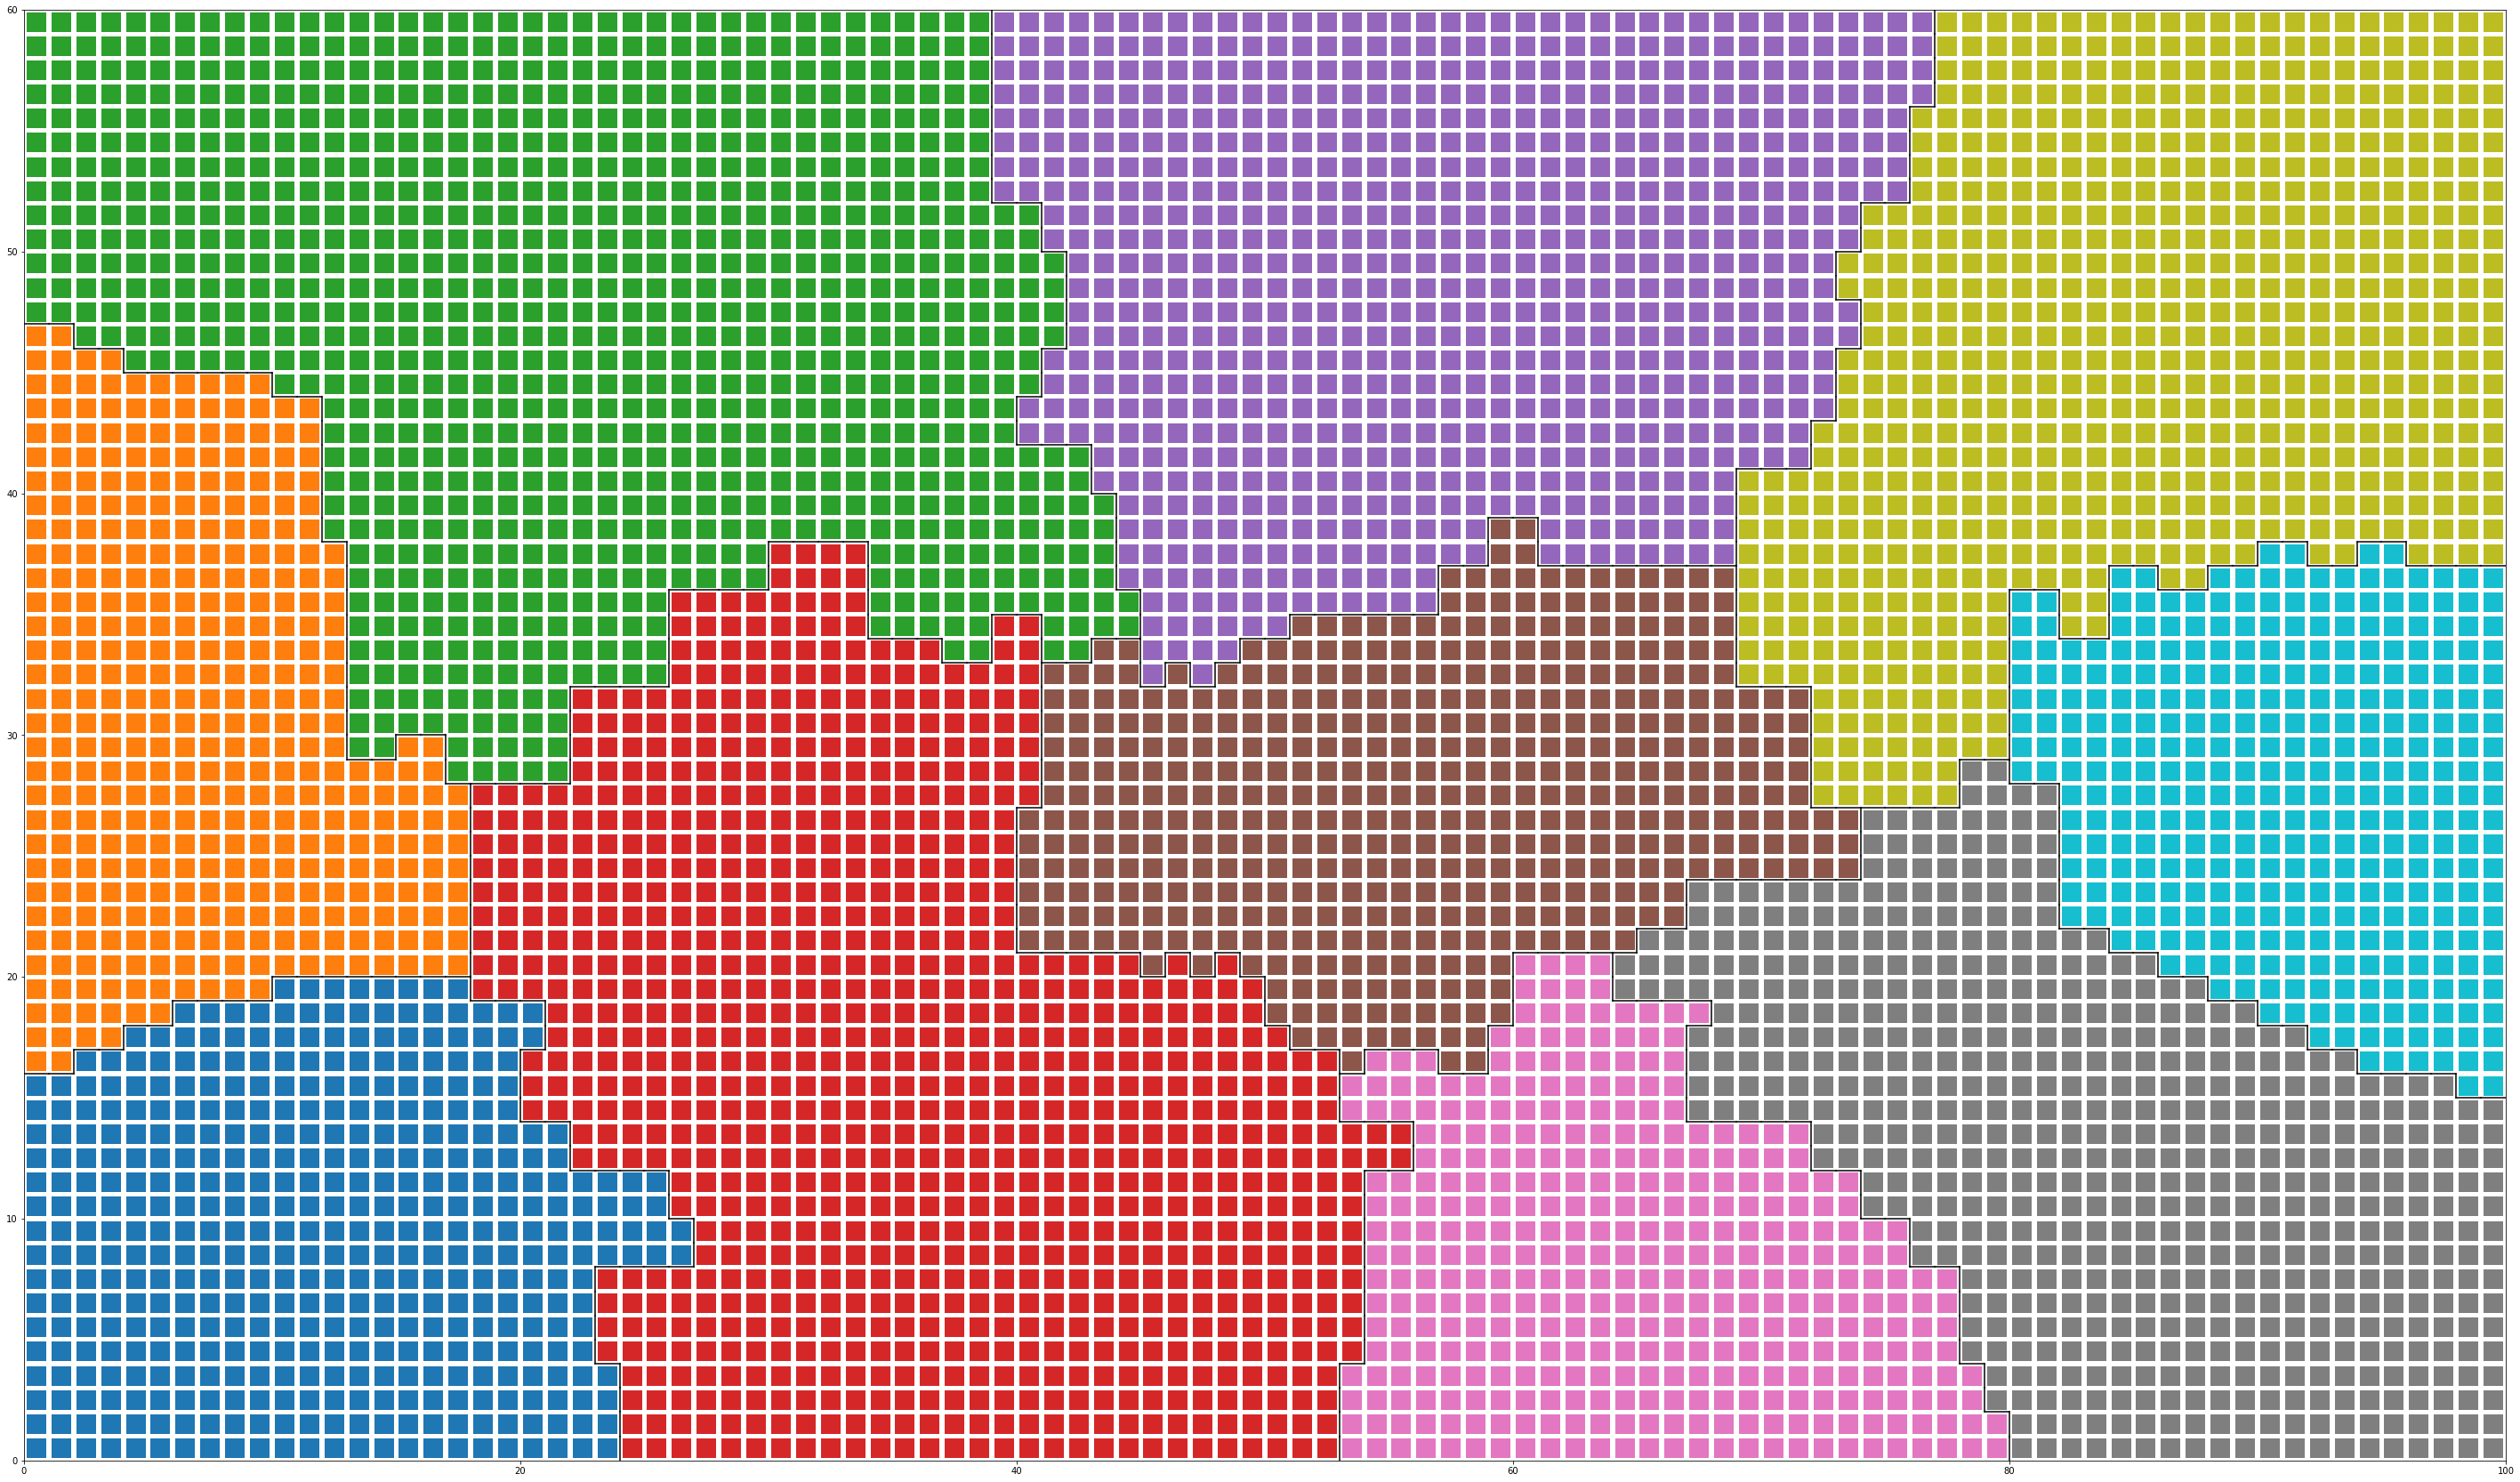

<Figure size 432x288 with 0 Axes>

In [147]:
hierarchical_clust_e(chainlink_som_big,100,60,10,'ward')

In [148]:
# =================================================== K-means CLUSTERING =================================

In [149]:

def kmeans_clust(som,d1,d2,n_clusters,random_state):
    weights = som.get_weights().reshape(d1*d2,-1) # first argument is product of first two dimensions of the input dataset
    labels = KMeans(n_clusters=n_clusters,random_state=random_state)
    km = labels.fit(weights)
    labels = km.labels_
    fig1=plot_with_labelling(som,d1,d2,labels,labels,weights,debug=False) 
    plt.draw()
    fig1.savefig('CHAINLINK-KM'+"-"+str(d1)+'x'+str(d2) , dpi=100)
    

In [150]:
def kmeans_clust_e(som,d1,d2,n_clusters,random_state):
    weights = som.get_weights().reshape(d1*d2,-1) # first argument is product of first two dimensions of the input dataset
    labels = KMeans(n_clusters=n_clusters,random_state=random_state)
    km = labels.fit(weights)
    labels = km.labels_
    fig1=plot_with_labelling(som,d1,d2,labels,labels,weights,debug=False) 
    plt.draw()
    fig1.savefig('CHAINLINK-KM'+"-"+str(d1)+'x'+str(d2)+"_e" , dpi=100)
    

In [151]:
# SMALL SOM

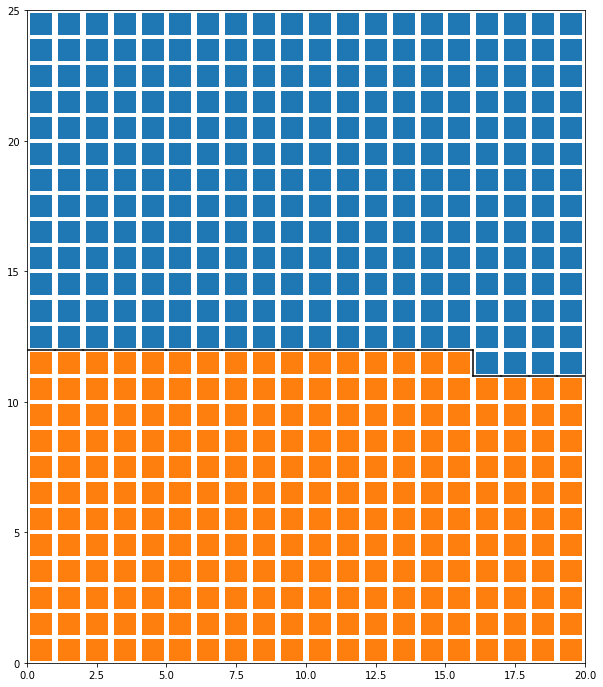

<Figure size 432x288 with 0 Axes>

In [152]:
kmeans_clust(chainlink_som_small,20,25,2,0)

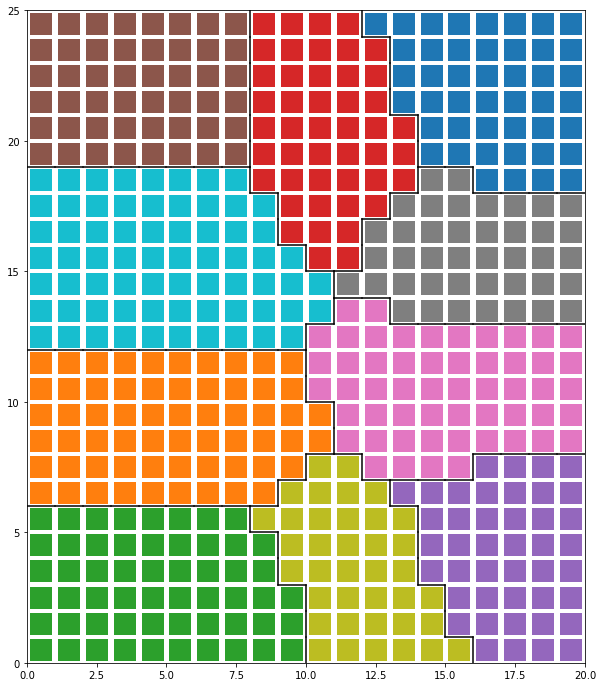

<Figure size 432x288 with 0 Axes>

In [153]:
#EXTREME VALUES

kmeans_clust_e(chainlink_som_small,20,25,10,10)



In [154]:
# BIG SOM

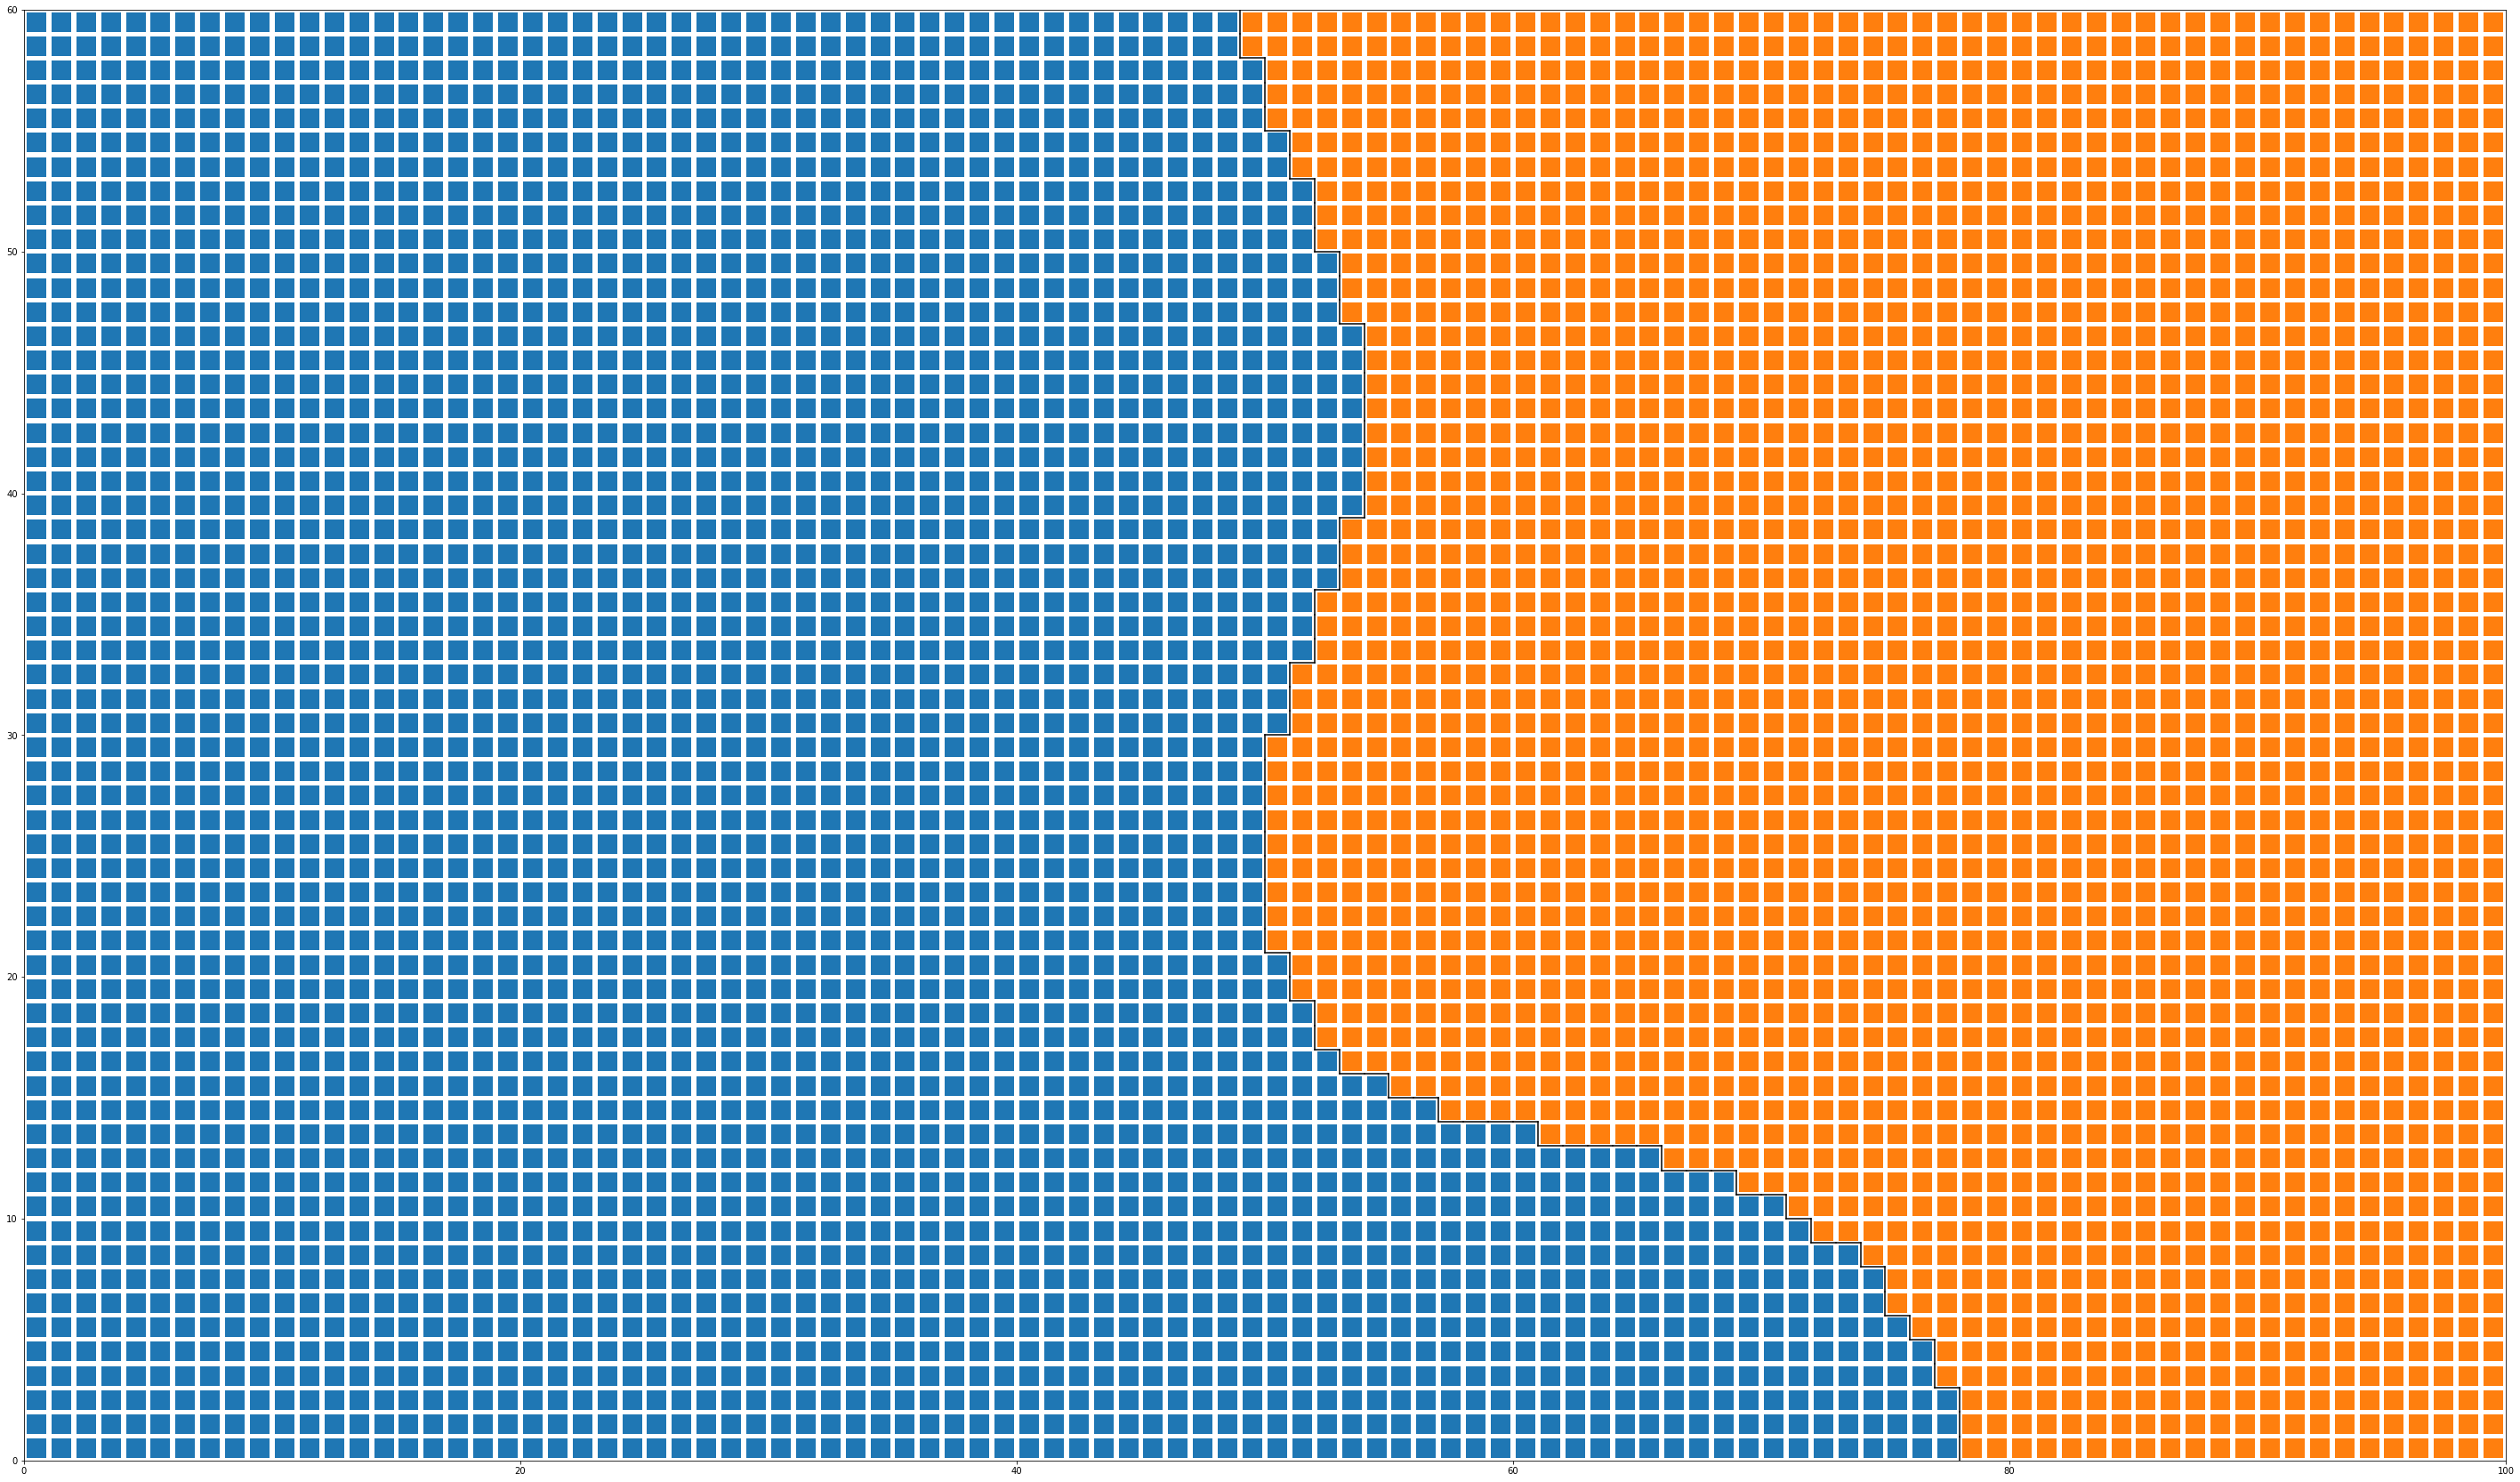

<Figure size 432x288 with 0 Axes>

In [155]:
kmeans_clust(chainlink_som_big,100,60,2,0)

In [ ]:
# EXTREME VALUES

kmeans_clust_e(chainlink_som_big,100,60,10,10)